In [173]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [174]:
@njit('f8(f8[:], f8[:], i8[:], i8[:], i8)', cache=True)
def lr_statistic(dur_1, dur_2, cens_1, cens_2, weightings):
    times = np.unique(np.hstack((dur_1, dur_2)))
    dur_1 = np.searchsorted(times, dur_1) + 1
    dur_2 = np.searchsorted(times, dur_2) + 1
    times_range = np.array([1, times.shape[0]], dtype=np.int32)

    bins = times_range[1] - times_range[0] + 1
    n_1_j = np.histogram(dur_1, bins=bins, range=times_range)[0]
    n_2_j = np.histogram(dur_2, bins=bins, range=times_range)[0]
    O_1_j = np.histogram(dur_1 * cens_1, bins=bins, range=times_range)[0]
    O_2_j = np.histogram(dur_2 * cens_2, bins=bins, range=times_range)[0]

    N_1_j = np.cumsum(n_1_j[::-1])[::-1]
    N_2_j = np.cumsum(n_2_j[::-1])[::-1]
    ind = np.where(N_1_j * N_2_j != 0)
    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = O_1_j[ind]
    O_2_j = O_2_j[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    res[:, 0] = 1.0
    # if np.any(N_j <= 1):
    #     return 0.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    logrank = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    return logrank


def weight_lr_fast(dur_A, dur_B, cens_A=None, cens_B=None, weightings=""):
    try:
        if cens_A is None:
            cens_A = np.ones(dur_A.shape[0])
        if cens_B is None:
            cens_B = np.ones(dur_B.shape[0])
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4}
        weightings = d.get(weightings, 1)
        logrank = lr_statistic(dur_A.astype("float64"),
                               dur_B.astype("float64"),
                               cens_A.astype("int64"),
                               cens_B.astype("int64"),
                               np.int64(weightings))
        return logrank
    except Exception as err:
        return 0.0
    
def logrank(durations_A, durations_B, event_observed_A=None, event_observed_B=None):
    return weight_lr_fast(durations_A, durations_B, event_observed_A, event_observed_B)

In [175]:
def transform_woe(x_feat, y):
    a = np.vstack([x_feat, y]).T
    a = a[a[:, 0] == a[:, 0]]

    # categs = np.unique(a[:, 0]).shape[0]
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - y.sum()

    df_woe_iv = pd.crosstab(a[:, 0], a[:, 1])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    df_woe_iv["p_bd"] = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    df_woe_iv["p_bd_"] = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    df_woe_iv["p_b_d"] = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    df_woe_iv["p_b_d_"] = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    df_woe_iv["woe_pl"] = np.log(df_woe_iv["p_bd"] / df_woe_iv["p_bd_"])
    df_woe_iv["woe_mn"] = np.log(df_woe_iv["p_b_d"] / df_woe_iv["p_b_d_"])
    features_woe = (df_woe_iv["woe_pl"] - df_woe_iv["woe_mn"]).to_dict()
    descr_np = np.vstack([df_woe_iv.index, (df_woe_iv["woe_pl"] - df_woe_iv["woe_mn"])])
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    # calculate information value
    # iv = ((df_woe_iv["p_bd"].to_numpy() - df_woe_iv["p_bd_"].to_numpy())*df_woe_iv["woe_pl"].to_numpy()).sum()
    return (woe_x_feat, descr_np)


def optimal_criter_split(arr_nan, left, right, criterion):
    none_to = 0
    max_stat_val = 1.0
    if arr_nan.shape[1] > 0:
        left_and_nan = np.hstack([left, arr_nan])
        right_and_nan = np.hstack([right, arr_nan])
        a = criterion(left_and_nan[1], right[1], left_and_nan[0], right[0])
        b = criterion(left[1], right_and_nan[1], left[0], right_and_nan[0])
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
#         print(a, b)
    else:
        max_stat_val = criterion(left[1], right[1], left[0], right[0])
    return (max_stat_val, none_to)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh+nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh+nan_sh, r_sh)
    return attrs


def get_cont_attrs(uniq_set, arr_notnan, arr_nan, min_samples_leaf, criterion, 
                   signif_val, thres_cont_bin_max):
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(arr_notnan[0], [i/float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:  # Set intermediate points
        uniq_set = (uniq_set[:-1] + uniq_set[1:])*0.5
    uniq_set = list(set(np.round(uniq_set, 3)))
    attr_dicts = []
    for value in uniq_set:
        # Filter by attr value
        ind = arr_notnan[0] >= value
        left = arr_notnan[1:, np.where(ind)[0]].astype(np.int32)  # inaccuracy in stat values
        right = arr_notnan[1:, np.where(~ind)[0]].astype(np.int32)
        
        if min(left.shape[1], right.shape[1]) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split(arr_nan, left, right, criterion)
        if max_stat_val >= signif_val:
            attr_loc = get_attrs(max_stat_val, value, none_to,
                                 left.shape[1], right.shape[1], arr_nan.shape[1])
            attr_dicts.append(attr_loc)
#         print(value, max_stat_val)
    return attr_dicts


def get_categ_attrs(uniq_set, arr_notnan, arr_nan, min_samples_leaf, criterion, signif_val):
    attr_dicts = []
    pairs_uniq = power_set_nonover(uniq_set)
    for l, r in pairs_uniq:
        left = arr_notnan[1:, np.isin(arr_notnan[0], l)].astype(np.int32)
        right = arr_notnan[1:, np.isin(arr_notnan[0], r)].astype(np.int32)
        if min(left.shape[1], right.shape[1]) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split(arr_nan, left, right, criterion)
        if max_stat_val >= signif_val:
            attr_loc = get_attrs(max_stat_val, [list(l), list(r)], none_to,
                                 left.shape[1], right.shape[1], arr_nan.shape[1])
            attr_dicts.append(attr_loc)
    return attr_dicts


def best_attr_split(arr, criterion="logrank", type_attr="cont", thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
#     criterion = crit.CRITERIA_DICT.get(criterion, None)
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2*min_samples_leaf:
        return best_attr

    ind = np.isnan(arr[0])
    arr_nan = arr[1:, np.where(ind)[0]].astype(np.int32)
    arr_notnan = arr[:, np.where(~ind)[0]]
    
    if type_attr == "woe":
        arr_notnan[0], descr_np = transform_woe(arr_notnan[0], arr_notnan[1])
        
    
    uniq_set = np.unique(arr_notnan[0])
    
    if type_attr == "categ" and uniq_set.shape[0] > 0:
        attr_dicts = get_categ_attrs(uniq_set, arr_notnan, arr_nan,
                                     min_samples_leaf, logrank, signif_stat)
    else:
        attr_dicts = get_cont_attrs(uniq_set, arr_notnan, arr_nan,
                                    min_samples_leaf, logrank, signif_stat, thres_cont_bin_max)
    
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" >= {best_attr['values']}", f" < {best_attr['values']}"]
        elif type_attr == "categ":
            best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe":
            ind = descr_np[1] >= best_attr["values"]
            l, r = list(descr_np[0, np.where(ind)[0]]), list(descr_np[0, np.where(~ind)[0]])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
        if verbose > 0:
            print(best_attr["p_value"], len(uniq_set))
    return best_attr

### NEW SPLITTING

In [322]:
@njit('f8(u4[:], u4[:], u4[:], u4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2, 
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    
    #     ind = np.where(N_1_j + N_2_j != 0) #
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
    if ind.shape[0] == 0:
        return 0.0
    
    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]
    
    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    res[:, 0] = 1.0
    
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
    stat_val = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    return stat_val

def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        weightings = d.get(weightings, 1)
        logrank = lr_hist_statistic(time_hist_1.astype("uint32"),
                                    time_hist_2.astype("uint32"),
                                    cens_hist_1.astype("uint32"),
                                    cens_hist_2.astype("uint32"),
                                    np.uint32(weightings),
                                    weights_hist.astype("float32"))
        return logrank
    except Exception as err:
        print(err)
        return 0.0

def optimal_criter_split_hist(left_time_hist, left_cens_hist, 
                         right_time_hist, right_cens_hist,
                         na_time_hist, na_cens_hist, weights_hist, criterion):
    none_to = 0
    max_stat_val = 1.0
    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist, right_time_hist, 
                             left_cens_hist + na_cens_hist, right_cens_hist, 
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist, right_time_hist + na_time_hist, 
                             left_cens_hist, right_cens_hist + na_cens_hist, 
                             weights_hist, weightings=criterion)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
#         print(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist, right_time_hist, 
                                        left_cens_hist, right_cens_hist, 
                                        weights_hist, weightings=criterion)
    return (max_stat_val, none_to)

def split_time_to_bins(time):
    return np.searchsorted(np.unique(time), time)

def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh+nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh+nan_sh, r_sh)
    return attrs

In [323]:
# def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", thres_cont_bin_max=100,
#                          signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
#     criterion = crit.CRITERIA_DICT.get(criterion, None)
#     best_attr = {"stat_val": signif_stat, "p_value": signif,
#                  "sign_split": 0, "values": [], "pos_nan": [1, 0]}
#     if arr.shape[1] < 2*min_samples_leaf:
#         return best_attr
#     vals = arr[0]
#     cens = arr[1]
#     dur = arr[2]
    
#     dur = split_time_to_bins(dur)
#     time_bins = np.unique(dur)
#     ind = np.isnan(vals)

#     # split nan and not-nan
#     dur_notna = dur[~ind]
#     cens_notna = cens[~ind]
#     vals_notna = vals[~ind]

#     # find splitting values
#     uniq_set = np.unique(vals_notna)
#     if uniq_set.shape[0] > thres_cont_bin_max:
#         uniq_set = np.quantile(vals_notna, [i/float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
#     else:
#         uniq_set = (uniq_set[:-1] + uniq_set[1:])*0.5
#     uniq_set = np.unique(np.round(uniq_set, 3))
#     index_vals_bin = np.digitize(vals_notna, uniq_set)

#     # find global hist by times
#     na_time_hist = np.bincount(dur[ind])
#     na_cens_hist = np.bincount(dur[ind], weights=cens[ind])
# #     print(na_time_hist)
# #     print(na_cens_hist)

#     right_time_hist = np.bincount(dur_notna)
#     right_cens_hist = np.bincount(dur_notna, weights=cens_notna)
#     left_time_hist = np.zeros_like(right_cens_hist, dtype=np.int32)
#     left_cens_hist = left_time_hist.copy()
    
#     num_nan = ind.sum()
#     num_r = dur_notna.shape[0]
#     num_l = 0

#     # for each split values get branches
#     attr_dicts = []
#     for u in np.unique(index_vals_bin)[:-1]:
#         curr_mask = index_vals_bin == u
#         curr_n = curr_mask.sum()
#         curr_time_hist = np.bincount(dur_notna, weights=curr_mask).astype("int32")
#         curr_cens_hist = np.bincount(dur_notna, weights=cens_notna*curr_mask).astype("int32")
#         left_time_hist += curr_time_hist
#         left_cens_hist += curr_cens_hist
#         right_time_hist -= curr_time_hist
#         right_cens_hist -= curr_cens_hist
#         num_l += curr_n
#         num_r -= curr_n
        
#         if min(num_l, num_r) <= min_samples_leaf:
#             continue
#         max_stat_val, none_to = optimal_criter_split_hist(left_time_hist, left_cens_hist, 
#                                                      right_time_hist, right_cens_hist,
#                                                      na_time_hist, na_cens_hist, logrank_hist)
        
#         if max_stat_val >= signif_stat:
#             attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
#             attr_dicts.append(attr_loc)
# #         print(uniq_set[u], max_stat_val)
    
#     if len(attr_dicts) == 0:
#         return best_attr
#     best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
#     best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
#     best_attr["sign_split"] = len(attr_dicts)
#     if best_attr["sign_split"] > 0:
#         if type_attr == "cont":
#             best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
#         elif type_attr == "categ":
#             best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
#         elif type_attr == "woe":
#             ind = descr_np[1] >= best_attr["values"]
#             l, r = list(descr_np[0, np.where(ind)[0]]), list(descr_np[0, np.where(~ind)[0]])
#             best_attr["values"] = [f" in {e}" for e in [l, r]]
#         if bonf:
#             best_attr["p_value"] *= best_attr["sign_split"]
#         if verbose > 0:
#             print(best_attr["p_value"], len(uniq_set))
#     return best_attr

In [325]:
def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    # calculate information value
    # iv = ((p_bd - p_bd_)*woe_pl).sum()
    return (woe_x_feat, descr_np)

def get_sa_hists(time, cens, minlength=1):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength).astype("int32")
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist

def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
#         elif type_attr == "categ":
#             best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr

def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2*min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    
    dur = split_time_to_bins(dur)
    max_bin = dur.max()
    
    ind = np.isnan(vals)
    
    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]
    
    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr
    
    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)
        
    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i/float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:])*0.5
    uniq_set = np.unique(np.round(uniq_set, 3))
    
    index_vals_bin = np.digitize(vals_notna, uniq_set)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind], minlength=max_bin+1)
    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna, minlength=max_bin+1)
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.int32)
    l_cens_hist = l_time_hist.copy()
    
    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0
    
    if weights is None:
        weights_hist = None
    else:
        weights_hist = np.bincount(dur, weights=weights, minlength=max_bin+1)
    
    # for each split values get branches
    attr_dicts = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask],
                                                      cens_notna[curr_mask],
                                                      minlength=max_bin+1)
        l_time_hist += curr_time_hist
        l_cens_hist += curr_cens_hist
        r_time_hist -= curr_time_hist
        r_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n
        
        if min(num_l, num_r) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion)
        
        if max_stat_val >= signif_stat:
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
            attr_dicts.append(attr_loc)
#         print(uniq_set[u], max_stat_val)

    if len(attr_dicts) == 0:
        return best_attr
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    if verbose > 0:
        print(best_attr["p_value"], len(uniq_set))
    return best_attr

### DATA CONVERGENCE TEST

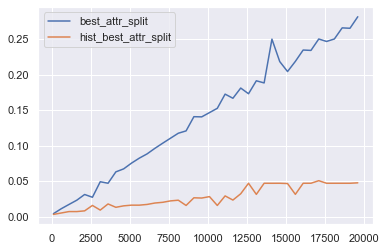

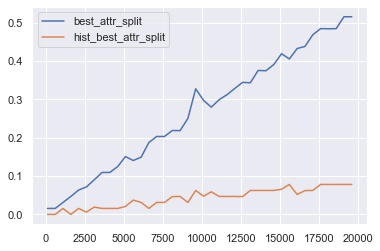

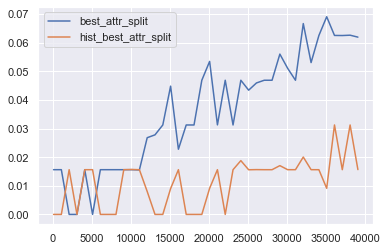

In [326]:
def get_data_sample(size, val_type="cont",  has_nan=False):
    dur = np.random.uniform(0, 10000, size)
    cens = np.random.choice(2, size)
    if val_type == "cont":
        vals = np.random.uniform(100, 8000, size)
    else:
        vals = np.random.choice(10, size)

    if has_nan:
        nan_index = np.random.uniform(0, 1, size) < 0.25
        vals[nan_index] = np.nan
    return np.vstack([vals, cens, dur])

def plot_performance_scaling_test(functions, size_samples, val_type="cont",  has_nan=False, **kwargs):
    times = {func.__name__ : [] for func in functions}
    res = {func.__name__ : [] for func in functions}
    for i in size_samples:
        arr = get_data_sample(size=i, val_type=val_type, has_nan=has_nan)
        
        for func in functions:
            time_start = time.time()
            res[func.__name__].append(func(arr, **kwargs))
            times[func.__name__].append(time.time() - time_start)
    
    fig = plt.figure()
    for func in functions:
        plt.plot(size_samples, times[func.__name__], label = func.__name__)
    plt.legend()
    plt.show()
    return times, res

def save_pstats(function, size_samples, val_type="cont",  has_nan=False, **kwargs):
    profiler = cProfile.Profile()
    for i in size_samples:
        arr = get_data_sample(size=i, val_type=val_type,  has_nan=has_nan)
        profiler.enable()
        function(arr)
        profiler.disable()
    stats_ = pstats.Stats(profiler).sort_stats('cumtime')
    stats_.print_stats()
    stats_.dump_stats(f"{function.__name__}.pstats")
    
times, res = plot_performance_scaling_test([best_attr_split, 
                                            hist_best_attr_split],
                                           range(100, 20000, 500))

times_nan, res_nan = plot_performance_scaling_test([best_attr_split, 
                                                    hist_best_attr_split],
                                                   range(100, 20000, 500),
                                                   has_nan = True)

times_woe, res_woe = plot_performance_scaling_test([best_attr_split, 
                                                    hist_best_attr_split],
                                                   range(100, 40000, 1000), 
                                                   val_type="categ",
                                                   type_attr="woe")

In [315]:
res

{'best_attr_split': [{'stat_val': 1.596392035484314,
   'values': [' >= 5788.43', ' < 5788.43'],
   'pos_nan': [1, 0],
   'min_split': 30,
   'p_value': 16.306805716764764,
   'sign_split': 79},
  {'stat_val': 5.263920307159424,
   'values': [' >= 719.971', ' < 719.971'],
   'pos_nan': [1, 0],
   'min_split': 60,
   'p_value': 2.1118766178271464,
   'sign_split': 97},
  {'stat_val': 10.931984901428223,
   'values': [' >= 492.316', ' < 492.316'],
   'pos_nan': [1, 0],
   'min_split': 55,
   'p_value': 0.09357299646860119,
   'sign_split': 99},
  {'stat_val': 7.199066162109375,
   'values': [' >= 7158.524', ' < 7158.524'],
   'pos_nan': [1, 0],
   'min_split': 160,
   'p_value': 0.7221211204840906,
   'sign_split': 99},
  {'stat_val': 2.845433235168457,
   'values': [' >= 538.879', ' < 538.879'],
   'pos_nan': [1, 0],
   'min_split': 126,
   'p_value': 9.071755195559716,
   'sign_split': 99},
  {'stat_val': 6.294848918914795,
   'values': [' >= 407.484', ' < 407.484'],
   'pos_nan': [1, 

In [327]:
for res_ in [res, res_nan, res_woe]:
    print(np.all([r1['min_split'] == r2['min_split'] for r1, r2 in zip(res_["best_attr_split"], 
                                                                       res_["hist_best_attr_split"])]))

False
True
True


In [328]:
for i, j in zip(res["best_attr_split"], res["hist_best_attr_split"]):
    print(i["stat_val"], j["stat_val"])
    print(i["values"], j["values"])
    print(i["pos_nan"], j["pos_nan"])
    print(i["min_split"], j["min_split"])

3.45402193069458 3.45402193069458
[' >= 1316.951', ' < 1316.951'] [' <= 1316.951', ' > 1316.951']
[1, 0] [1, 0]
14 14
1.6790144443511963 1.6836191415786743
[' >= 1356.084', ' < 1356.084'] [' <= 1356.084', ' > 1356.084']
[1, 0] [1, 0]
102 102
2.7333106994628906 2.730503797531128
[' >= 5460.355', ' < 5460.355'] [' <= 5460.355', ' > 5460.355']
[1, 0] [1, 0]
352 352
5.484597206115723 5.49252462387085
[' >= 7699.26', ' < 7699.26'] [' <= 7699.26', ' > 7699.26']
[1, 0] [1, 0]
64 64
2.9351818561553955 2.941075325012207
[' >= 5733.069', ' < 5733.069'] [' <= 5733.069', ' > 5733.069']
[1, 0] [1, 0]
630 630
3.5639467239379883 3.568918466567993
[' >= 486.867', ' < 486.867'] [' <= 486.867', ' > 486.867']
[1, 0] [1, 0]
130 130
1.97104012966156 1.9723451137542725
[' >= 173.589', ' < 173.589'] [' <= 173.589', ' > 173.589']
[1, 0] [1, 0]
31 31
3.5995423793792725 3.5967013835906982
[' >= 5666.799', ' < 5666.799'] [' <= 5666.799', ' > 5666.799']
[1, 0] [1, 0]
1044 1044
3.13193941116333 3.126537799835205
[

### Тестирование

In [740]:
dur = np.random.uniform(0, 10000, 9600)
cens = np.random.choice(2, 9600)
vals = np.random.uniform(100, 8000, 9600)
# nan_index = np.random.uniform(0, 1, 9600) < 0.15
# vals[nan_index] = np.nan

arr = np.vstack([vals, cens, dur])

In [741]:
print(best_attr_split(arr))
print(miss_hist_best_attr_split(arr))
print(hist_best_attr_split(arr))

{'stat_val': 7.322624206542969, 'values': [' >= 638.381', ' < 638.381'], 'pos_nan': [1, 0], 'min_split': 672, 'p_value': 0.6741099587390308, 'sign_split': 99}
{'stat_val': 7.322624206542969, 'values': [' <= 638.381', ' > 638.381'], 'pos_nan': [1, 0], 'min_split': 672, 'p_value': 0.6741099587390308, 'sign_split': 99}
{'stat_val': 7.322624206542969, 'values': [' <= 638.381', ' > 638.381'], 'pos_nan': [1, 0], 'min_split': 672, 'p_value': 0.6741099587390308, 'sign_split': 99}


In [757]:
%timeit best_attr_split(arr)
%timeit miss_hist_best_attr_split(arr)
%timeit hist_best_attr_split(arr)

140 ms ± 521 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.8 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.9 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [753]:
%timeit best_attr_split(arr)
%timeit miss_hist_best_attr_split(arr)
%timeit hist_best_attr_split(arr)

140 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.6 ms ± 91.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.5 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Тестирование WOE

In [687]:
dur_woe = np.random.uniform(0, 10000, 8000)
cens_woe = np.random.choice(2, 8000)
vals_woe = np.random.choice(10, 8000)

%timeit transform_woe_np(vals_woe, cens_woe)

1.7 ms ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [688]:
%timeit transform_woe(vals_woe, cens_woe)

7.77 ms ± 85.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [814]:
dur = np.random.uniform(0, 10000, 10000)
cens = np.random.choice(2, 10000)
vals = np.random.uniform(100, 8000, 10000)
weights = np.random.uniform(0, 1, 10000)

arr = np.vstack([vals, cens, dur])
hist_best_attr_split(arr, weights = weights)

{'stat_val': 5.270829200744629,
 'values': [' <= 419.701', ' > 419.701'],
 'pos_nan': [1, 0],
 'min_split': 400,
 'p_value': 2.1468823686781655,
 'sign_split': 99}

In [815]:
hist_best_attr_split(arr)

{'stat_val': 5.270829200744629,
 'values': [' <= 419.701', ' > 419.701'],
 'pos_nan': [1, 0],
 'min_split': 400,
 'p_value': 2.1468823686781655,
 'sign_split': 99}

In [818]:
hist_best_attr_split(arr, weights = weights, criterion = "weights")

{'stat_val': 3.261937141418457,
 'values': [' <= 500.153', ' > 500.153'],
 'pos_nan': [1, 0],
 'min_split': 500,
 'p_value': 7.01962647731446,
 'sign_split': 99}

In [819]:
hist_best_attr_split(arr, weights = weights, criterion = "peto")

{'stat_val': 4.412639141082764,
 'values': [' <= 419.701', ' > 419.701'],
 'pos_nan': [1, 0],
 'min_split': 400,
 'p_value': 3.531687406426234,
 'sign_split': 99}

In [823]:
hist_best_attr_split(arr, weights = weights, criterion = "wilcoxon")

{'stat_val': 5.024910926818848,
 'values': [' <= 500.153', ' > 500.153'],
 'pos_nan': [1, 0],
 'min_split': 500,
 'p_value': 2.473535860622107,
 'sign_split': 99}

In [883]:
hist_best_attr_split(arr, type_attr="cont")

{'stat_val': 12.245074272155762,
 'values': [' <= 1716.74', ' > 1716.74'],
 'pos_nan': [1, 0],
 'min_split': 103,
 'p_value': 0.043383380848401355,
 'sign_split': 93}

In [886]:
hist_best_attr_split(arr, type_attr="cont")

{'stat_val': 12.245074272155762,
 'values': [' <= 1716.74', ' > 1716.74'],
 'pos_nan': [1, 0],
 'min_split': 103,
 'p_value': 0.043383380848401355,
 'sign_split': 93}

In [898]:
best_attr_split(arr, type_attr="categ")

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed
from scipy import stats

from survivors import constants as cnt
from survivors.tree.stratified_model import LEAF_MODEL_DICT

sns.set()

"""" Auxiliary functions """


def join_dict(a, b):
    return dict(list(a.items()) + list(b.items()))


class Rule(object):
    def __init__(self, feature: str, condition: str, has_nan: int):
        self.feature = feature
        self.condition = condition
        self.has_nan_ = has_nan

    def get_feature(self):
        return self.feature

    def get_condition(self):
        return self.condition

    def has_nan(self):
        return self.has_nan_

    def translate(self, describe):
        self.feature = describe.get(self.feature, self.feature)

    def to_str(self):
        s = f"({self.feature}{self.condition})"
        if self.has_nan_:
            s = f"({s}| nan)"  # не указано)"
        return s


""" Класс вершины дерева решений """
class Node(object):
    def __init__(self, df,  numb=0, full_rule=[],
                 depth=0, features=[], categ=[], woe=False,
                 verbose=0, leaf_model="base", **info):
        self.df = df
        self.numb = numb
        self.full_rule = full_rule
        self.depth = depth
        self.edges = np.array([], dtype=int)
        self.rule_edges = np.array([], dtype=Rule)
        self.features = features
        self.categ = categ
        self.woe = woe
        self.is_leaf = True
        self.verbose = verbose
        self.info = info
        self.leaf_model = LEAF_MODEL_DICT.get(leaf_model, "base")()
        self.check_params()

    def check_params(self):
        self.info.setdefault("bonf", True)
        self.info.setdefault("n_jobs", 16)
        self.info.setdefault("max_features", 1.0)
        self.info.setdefault("signif", 1.1)
        self.info.setdefault("signif_stat", stats.chi2.isf(min(self.info["signif"], 1.0), df=1))
        self.info.setdefault("thres_cont_bin_max", 100)
        if self.info["max_features"] == "sqrt":
            self.info["max_features"] = int(np.trunc(np.sqrt(len(self.features))+0.5))
        elif isinstance(self.info["max_features"], float):
            self.info["max_features"] = int(self.info["max_features"]*len(self.features))
        self.leaf_model.fit(self.df)

    """ GROUP FUNCTIONS: CREATE LEAVES """
    def get_comb_fast(self, features):
        X = self.df.loc[:, features + [cnt.CENS_NAME, cnt.TIME_NAME]].to_numpy().T

        def create_params_f(v_feature, name):
            d = self.info.copy()
            d["arr"] = np.vstack((v_feature, X[-2:]))
            d["type_attr"] = ("woe" if self.woe else "categ") if name in self.categ else "cont"
            return d

        return list(map(create_params_f, X[:-2], features))

    def get_comb(self, features):
        args = np.array([], dtype=dict)
        for feat in features:
            t = self.info.copy()
            t["type_attr"] = ("woe" if self.woe else "categ") if feat in self.categ else "cont"
            t["arr"] = self.df.loc[:, [feat, cnt.CENS_NAME, cnt.TIME_NAME]].to_numpy().T
            args = np.append(args, t)
        return args

    def find_best_split(self):
        numb_feats = self.info["max_features"]
        numb_feats = np.clip(numb_feats, 1, len(self.features))
        n_jobs = min(numb_feats, self.info["n_jobs"])

        selected_feats = list(np.random.choice(self.features, size=numb_feats, replace=False))
        # args = self.get_comb(selected_feats)
        args = self.get_comb_fast(selected_feats)

        ml = np.vectorize(lambda x: hist_best_attr_split(**x))(args)

#         with Parallel(n_jobs=n_jobs, verbose=0, batch_size=10) as parallel:  # prefer="threads"
#             ml = parallel(delayed(hist_best_attr_split)(**a) for a in args)
        attrs = {f: ml[ind] for ind, f in enumerate(selected_feats)}

        attr = min(attrs, key=lambda x: attrs[x]["p_value"])
        if attrs[attr]["sign_split"] > 0 and self.info["bonf"]:
            attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]
        return (attr, attrs[attr])

    def split(self):
        node_edges = np.array([], dtype=int)
        self.rule_edges = np.array([], dtype=Rule)

        attr, best_split = self.find_best_split()
        # The best split is not significant
        if best_split["sign_split"] == 0:
            if self.verbose > 0:
                print(f'Конец ветви, незначащее p-value: {best_split["p_value"]}')
            return node_edges

        if self.verbose > 0:
            print('='*6, best_split["p_value"], attr)
        for v, p_n in zip(best_split["values"], best_split["pos_nan"]):
            query = attr + v
            if p_n == 1:
                query = "(" + attr + v + ") or (" + attr + " != " + attr + ")"
            rule = Rule(feature=attr, condition=v, has_nan=p_n)
            d_node = self.df.query(query).copy()
            N = Node(df=d_node, full_rule=self.full_rule + [rule],
                     features=self.features, categ=self.categ,
                     depth=self.depth+1, verbose=self.verbose, **self.info)
            node_edges = np.append(node_edges, N)
            self.rule_edges = np.append(self.rule_edges, rule)

        return node_edges

    def set_edges(self, edges):
        self.edges = edges
        self.is_leaf = False
        self.df = None

    def set_leaf(self):
        if self.is_leaf:
            return
        self.edges = np.array([], dtype=int)
        self.is_leaf = True

    def prepare_df_for_attr(self, X):
        attr = self.rule_edges[0].get_feature()
        if attr not in X.columns:
            X.loc[:, attr] = np.nan
        return X[attr].to_numpy()

    def get_edges(self, X):
        X_np = self.prepare_df_for_attr(X)
        rule_id = 1 if self.rule_edges[0].has_nan() else 0
        query = self.rule_edges[rule_id].get_condition()
        if self.rule_edges[0].get_feature() in self.categ:
            values = np.isin(X_np, eval(query[query.find("["):]))
        else:
            values = eval("X_np" + query)
        return np.where(values, self.edges[rule_id], self.edges[1-rule_id])

    def get_full_rule(self):
        return " & ".join([s.to_str() for s in self.full_rule])

    def predict(self, X, target, bins=None):
        res = np.full((X.shape[0]), np.nan, dtype=object)
        if target == "surv":
            res = self.leaf_model.predict_survival_at_times(X, bins)  # target(X_node=dataset)
        elif target == "hazard":
            res = self.leaf_model.predict_hazard_at_times(X, bins)
        elif target in self.__dict__:
            res = np.repeat(getattr(self, target, np.nan), X.shape[0], axis=0)
        else:
            res = self.leaf_model.predict_mean_feature(X, target)  # np.mean(dataset[target])
        return res

    def predict_scheme(self, X, scheme_feats):
        feat_means = np.array([self.leaf_model.features_mean.get(s_f, np.nan)
                               for s_f in scheme_feats])
        times = self.leaf_model.predict_list_feature(cnt.TIME_NAME)
        cens = self.leaf_model.predict_list_feature(cnt.CENS_NAME)

        return Scheme(self.get_full_rule(), times, cens, feat_means)

    """ GROUP FUNCTIONS: VISUALIZATION """

    def get_figure(self, mode="hist", bins=None, target=cnt.CENS_NAME, save_path=""):
        plt.ioff()
        fig, ax = plt.subplots(figsize=(8, 6))
        if mode == "hist":
            lst = self.leaf_model.predict_list_feature(target)
            plt.hist(lst, bins=25)
            ax.set_xlim([0, np.max(lst)])
            ax.set_xlabel(f'{target}', fontsize=25)
        elif mode == "surv":
            sf = self.leaf_model.predict_survival_at_times(X=None, bins=bins)
            plt.step(bins, sf)
            ax.set_xlabel('Time', fontsize=25)
            ax.set_ylabel('Survival probability', fontsize=25)
        plt.savefig(save_path)
        plt.close(fig)

    def get_description(self):
        m_cens = round(self.leaf_model.predict_mean_feature(X=None, feature_name=cnt.CENS_NAME), 2)
        m_time = round(self.leaf_model.predict_mean_feature(X=None, feature_name=cnt.TIME_NAME), 2)
        label = "\n".join([f"size = {self.leaf_model.get_shape()[0]}",
                           f"cens/size = {m_cens}",
                           f"depth = {self.depth}",
                           f"death = {m_time}"])
        return label

    def set_dot_node(self, dot, path_dir="", depth=None, **args):
        if not(depth is None) and depth < self.depth:
            return dot
        img_path = path_dir + str(self.numb) + '.png'
        self.get_figure(save_path=img_path, **args)
        dot.node(str(self.numb), label=self.get_description(),
                 image=img_path, fontsize='30')  # fontsize='16'
        return dot

    def set_dot_edges(self, dot):
        if not(self.is_leaf):
            for e in range(len(self.rule_edges)):
                s = self.rule_edges[e].to_str()
                dot.edge(str(self.numb), str(self.edges[e]), label=s, fontsize='30')
        return dot

    def translate(self, describe):
        if self.is_leaf:
            self.df = self.df.rename(describe, axis=1)
        self.features = [describe.get(f, f) for f in self.features]
        self.categ = [describe.get(c, c) for c in self.categ]
        for e in range(len(self.rule_edges)):
            self.rule_edges[e].translate(describe)

In [96]:
class CRAID(object):
    def __init__(self, depth=0,
                 random_state=123,
                 features=[],
                 categ=[],
                 cut=False,
                 **info):
        self.info = info
        self.cut = cut
        self.nodes = dict()
        self.depth = depth
        self.features = features
        self.categ = categ
        self.random_state = random_state
        self.name = f"CRAID_{self.random_state}"
        self.coxph = None
        self.ohenc = None
        self.bins = []

    def fit(self, X, y):
        if len(self.features) == 0:
            self.features = X.columns
        self.bins = cnt.get_bins(time=y[cnt.TIME_NAME])  # , cens = y[cnt.CENS_NAME])
        X = X.reset_index(drop=True)
        X_tr = X.copy()
        X_tr[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X_tr[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        if not ("min_samples_leaf" in self.info):
            self.info["min_samples_leaf"] = 0.01 * X_tr.shape[0]
        cnt.set_seed(self.random_state)

        if self.cut:
            X_val = X_tr.sample(n=int(0.2 * X_tr.shape[0]), random_state=self.random_state)
            X_tr = X_tr.loc[X_tr.index.difference(X_val.index), :]

        self.nodes[0] = Node(X_tr, features=self.features, categ=self.categ, **self.info)
        stack_nodes = np.array([0], dtype=int)
        while stack_nodes.shape[0] > 0:
            node = self.nodes[stack_nodes[0]]
            stack_nodes = stack_nodes[1:]
            if node.depth >= self.depth:
                continue
            sub_nodes = node.split()
            if sub_nodes.shape[0] > 0:
                sub_numbers = np.array([len(self.nodes) + i for i in range(sub_nodes.shape[0])])
                for i in range(sub_nodes.shape[0]):
                    sub_nodes[i].numb = sub_numbers[i]
                self.nodes.update(dict(zip(sub_numbers, sub_nodes)))
                node.set_edges(sub_numbers)
                stack_nodes = np.append(stack_nodes, sub_numbers)

        if self.cut:
            self.cut_tree(X_val, cnt.CENS_NAME, mode_f=roc_auc_score, choose_f=max)

#         self.fit_cox_hazard(X, y)
        return

    def fit_cox_hazard(self, X, y):
        self.coxph = CoxPHSurvivalAnalysis(alpha=0.1)
        self.ohenc = OneHotEncoder(handle_unknown='ignore')
        pred_node = self.predict(X, mode="target", target="numb").reshape(-1, 1)
        ohenc_node = self.ohenc.fit_transform(pred_node).toarray()
        self.coxph.fit(ohenc_node, y)

    def predict_cox_hazard(self, X, bins):
        bins = np.clip(bins, self.bins.min(), self.bins.max())
        pred_node = self.predict(X, mode="target", target="numb").reshape(-1, 1)
        ohenc_node = self.ohenc.transform(pred_node).toarray()
        hazards = self.coxph.predict_cumulative_hazard_function(ohenc_node)
        pred_haz = np.array(list(map(lambda x: x(bins), hazards)))
        return pred_haz

    def predict(self, X, mode="target", target=cnt.TIME_NAME, end_list=[], bins=None):
        X = format_to_pandas(X, self.features)
        num_node_to_key = dict(zip(sorted(self.nodes.keys()), range(len(self.nodes))))
        node_bin = np.zeros((X.shape[0], len(self.nodes)), dtype=bool)
        node_bin[:, 0] = 1
        shape = (X.shape[0])
        if not (bins is None):
            shape = (X.shape[0], len(bins))
        res = np.full(shape, np.nan, dtype=object)
        for i in sorted(self.nodes.keys()):
            ind = np.where(node_bin[:, num_node_to_key[i]])[0]
            ind_x = X.index[ind]
            if ind.shape[0] > 0:
                if self.nodes[i].is_leaf or (i in end_list):
                    if target == "surv" or target == "hazard":
                        res[ind] = self.nodes[i].predict(X.loc[ind_x, :], target, bins)
                    elif mode == "target":
                        res[ind] = self.nodes[i].predict(X.loc[ind_x, :], target)
                    elif mode == "rules":
                        res[ind] = self.nodes[i].get_full_rule()
                else:
                    pred_edges = self.nodes[i].get_edges(X.loc[ind_x, :])
                    for e in set(pred_edges):
                        node_bin[ind, num_node_to_key[e]] = pred_edges == e
        if not(mode == "rules"):
            res = res.astype(float)
        return res

    def predict_at_times(self, X, bins, mode="surv"):
        X = format_to_pandas(X, self.features)
        if mode == "cox-hazard":
            return self.predict_cox_hazard(X, bins)
        return self.predict(X, target=mode, bins=bins)

    def predict_schemes(self, X, scheme_feats):
        X = format_to_pandas(X, self.features)
        num_node_to_key = dict(zip(sorted(self.nodes.keys()), range(len(self.nodes))))
        node_bin = np.zeros((X.shape[0], len(self.nodes)), dtype=bool)
        node_bin[:, 0] = 1
        for i in sorted(self.nodes.keys()):
            i_num = num_node_to_key[i]
            ind = np.where(node_bin[:, i_num])[0]
            ind_x = X.index[ind]
            if ind.shape[0] > 0:
                if not (self.nodes[i].is_leaf):
                    if self.nodes[i].rule_edges[0].get_feature() in scheme_feats:
                        for e in self.nodes[i].edges:
                            node_bin[ind, num_node_to_key[e]] = 1
                    else:
                        pred_edges = self.nodes[i].get_edges(X.loc[ind_x, :])
                        for e in set(pred_edges):
                            node_bin[ind, num_node_to_key[e]] = pred_edges == e
        leaf_keys = self.get_leaf_numbers()
        leaf_numb = np.array([num_node_to_key[leaf] for leaf in leaf_keys])

        ret_leaf_numbers = np.where(node_bin[:, leaf_numb], leaf_keys, np.inf)

        dict_leaf_scheme = {n_l: self.nodes[n_l].predict_scheme(None, scheme_feats)
                            for n_l in np.unique(ret_leaf_numbers) if n_l != np.inf}
        dict_str_fill = {}
        for leaf_list in np.unique(ret_leaf_numbers, axis=0):
            end_leaf = leaf_list[leaf_list != np.inf]
            sch_list = np.vectorize(dict_leaf_scheme.get)(end_leaf)
            dict_str_fill[str(end_leaf)] = FilledSchemeStrategy(sch_list)

        # res = np.array([str(x[x != np.inf]) for x in ret_leaf_numbers]), dtype=object)
        # res = np.vectorize(dict_str_fill.get)(res)
        res = np.array(list(map(lambda leaf_list: dict_str_fill.get(str(leaf_list[leaf_list != np.inf]), np.nan),
                                ret_leaf_numbers)), dtype=object)
        return res

    def visualize(self, path_dir=None, **kwargs):
        if path_dir is None:
            path_dir = os.getcwd()
        kwargs["bins"] = self.bins

        with tempfile.TemporaryDirectory() as tmp_dir:
            dot = Digraph(node_attr={'shape': 'none'})
            ordered_nodes = sorted(self.nodes.keys())
            for i in ordered_nodes:
                dot = self.nodes[i].set_dot_node(dot, path_dir=tmp_dir, **kwargs)
            for i in ordered_nodes:
                dot = self.nodes[i].set_dot_edges(dot)
            dot.render(os.path.join(path_dir, self.name), view=False, cleanup=True, format="png")

    def translate(self, describe):
        self.features = [describe.get(f, f) for f in self.features]
        self.categ = [describe.get(c, c) for c in self.categ]
        for i in self.nodes.keys():
            self.nodes[i].translate(describe)

    """ Cutting methods """

    def get_leaf_numbers(self):
        return np.array([i for i in self.nodes.keys() if self.nodes[i].is_leaf])

    def get_spanning_leaf_numbers(self):
        leaves = self.get_leaf_numbers()
        return np.array([i for i in self.nodes.keys()
                         if np.intersect1d(self.nodes[i].edges, leaves).shape[0] == 2])

    def delete_leaves_by_span(self, list_span_leaf):
        for i in list_span_leaf:
            for e in self.nodes[i].edges:
                del self.nodes[e]
            self.nodes[i].set_leaf()

In [97]:
cr = CRAID(categ = ['trt', 'sex', 'ascites', 'hepato', 'spiders'],
      criterion = 'peto', depth = 10,
      max_features = 1.0, min_samples_leaf = 5, 
      signif = 0.05, woe = False)

In [329]:
from survivors.datasets import load_pbc_dataset
X, y, features, categ, t = load_pbc_dataset()
cr.fit(X, y)

In [351]:
hist_best_attr_split(arr, weights=np.ones_like(arr[0]), criterion = "weights")

{'stat_val': 18.896339416503906,
 'values': [' <= 64.5', ' > 64.5'],
 'pos_nan': [1, 0],
 'min_split': 38,
 'p_value': 0.0005244655634883362,
 'sign_split': 38}

In [341]:
X_ = X.copy()
X_["cens"] = y["cens"]
X_["time"] = y["time"]
arr = X_.loc[:,["age", "cens", "time"]].to_numpy().T.astype("int32")
%timeit hist_best_attr_split(arr)

2.16 ms ± 5.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [342]:
from survivors.tree.find_split import best_attr_split

In [352]:
%timeit best_attr_split(arr)

{'stat_val': 24.848939895629883,
 'values': [' >= 64.5', ' < 64.5'],
 'pos_nan': [1, 0],
 'min_split': 38,
 'p_value': 2.3561190879826136e-05,
 'sign_split': 38}

In [309]:
def np_from_str(s):
    return np.array(list(map(int, s[1:-1].split())), dtype=np.int32)

time_h_1 = np_from_str("[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]")
time_h_2 = np_from_str("[1 2 2 1 2 1 0 1 1 1 1 4 1 2 1 1 1 2 1 2 1 2 1 2 1 1 4 1 2]")
cens_h_1 = np_from_str("[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]")
cens_h_2 = np_from_str("[0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]")

weight_hist_stat(time_h_1, time_h_2,
                  cens_h_1, cens_h_2,
                  weightings = "logrank")

0.0

In [321]:
@njit('f8(u4[:], u4[:], u4[:], u4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2, 
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    
#     ind = np.where(N_1_j + N_2_j != 0) #
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
    if ind.shape[0] == 0:
        return 0.0
    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]
    
    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    res[:, 0] = 1.0
    
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
    stat_val = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    return stat_val

def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        weightings = d.get(weightings, 1)
        logrank = lr_hist_statistic(time_hist_1.astype("uint32"),
                                    time_hist_2.astype("uint32"),
                                    cens_hist_1.astype("uint32"),
                                    cens_hist_2.astype("uint32"),
                                    np.uint32(weightings),
                                    weights_hist.astype("float32"))
        return logrank
    except Exception as err:
        print(err)
        return 0.0

In [497]:
time_1 = np.random.choice(8000, 100)
time_2 = np.random.choice(8000, 100)
dur_max = max(time_1.max(), time_2.max())

cens_1 = np.random.choice(2, 100)
cens_2 = np.random.choice(2, 100)

time_h_1 = np.bincount(time_1, minlength = dur_max + 1)
cens_h_1 = np.bincount(time_1, weights=cens_1, minlength = dur_max + 1)

time_h_2 = np.bincount(time_2, minlength = dur_max + 1)
cens_h_2 = np.bincount(time_2, weights=cens_2, minlength = dur_max + 1)

In [308]:
weight_hist_stat(time_h_1, time_h_2,
                  cens_h_1, cens_h_2,
                  weightings = "logrank")

0.0032625501044094563

In [277]:
time_h_1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [282]:
pd.DataFrame(np.vstack([time_h_1, cens_h_1, time_h_2, cens_h_2]).T).describe()

,0,1,2,3
count,7999.000000,7999.000000,7999.000000,7999.000000
mean,0.012502,0.006001,0.012502,0.005376
std,0.111116,0.077237,0.111116,0.073126
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [280]:
time_h_2

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [436]:
def return_sf(dur, cens, bins):
    km = KaplanMeierFitter()
    km.fit(dur, cens)
    return km.survival_function_at_times(bins).to_numpy()

def return_sf_2(dur, cens, bins):
    bins_ = np.unique(dur)
    dur_ = np.searchsorted(bins_, dur)
    hist_dur = np.bincount(dur_)
    hist_cens = np.bincount(dur_, weights=cens)
    cumul_hist = np.cumsum(hist_dur[::-1])[::-1]
    sf = np.cumprod((1.0 - hist_cens / (cumul_hist)))
    
    place_bin = np.digitize(bins, bins_) - 1
    return sf[np.clip(place_bin, 0, None)]

dur = np.random.uniform(0, 10000, 10000)
cens = np.random.choice(2, 10000)
bins = np.sort(np.random.uniform(0, 10000, 100))

In [387]:
%timeit return_sf(dur, cens, bins)

13.7 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [388]:
%timeit return_sf_2(dur, cens, bins)

1.31 ms ± 7.03 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


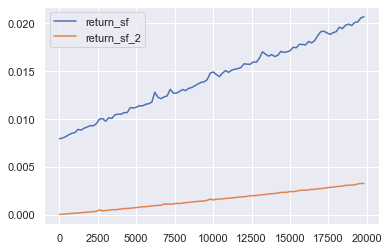

In [457]:
import timeit
def plot_km_performance_scaling_test(functions, size_samples):
    times = {func.__name__ : [] for func in functions}
    res = {func.__name__ : [] for func in functions}
    for i in size_samples:
        dur = np.random.uniform(0, 10000, i)
        cens = np.random.choice(2, i)
        bins = np.sort(np.random.uniform(0, 10000, i))
        
        for func in functions:
            sf_ = func(dur, cens, bins)
            
            res[func.__name__].append(sf_)
            times[func.__name__].append(timeit.timeit(lambda: func(dur, cens, bins), number=100)/100)
    
    fig = plt.figure()
    for func in functions:
        plt.plot(size_samples, times[func.__name__], label = func.__name__)
    plt.legend()
    plt.show()
    return times, res

times_km, res_km = plot_km_performance_scaling_test([return_sf, 
                                                     return_sf_2], 
                                                    range(10, 20000, 200))

In [482]:
return_sf(np.array([1, 10, 75, 100, 150]),
          np.array([1, 1, 1, 1, 1]),
          np.array([0.1, 5, 50]),
         )
# array([1. , 0.8, 0.6])
return_sf_2(np.array([1, 10, 75, 100, 150]),
          np.array([1, 1, 1, 1, 1]),
          np.array([0.1, 5, 50]),
         )
# array([0.8, 0.8, 0.6])

array([1. , 0.8, 0.6])

In [492]:
def full_query(X, query):
    return X.query(query)

def full_query_by_index(X, query, attr, categ):
    if attr in categ:
        values = np.isin(X[attr], eval(query[query.find("["):]))
    else:
        values = eval("X[attr]" + query)
    return X[values]

In [494]:
%timeit full_query_by_index(X, v, attr, [])

224 µs ± 997 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [486]:
attr = "age"
v = "<= 40.5"
query = "(" + attr + v + ") or (" + attr + " != " + attr + ")"
full_query(X, query)

,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk,ast,trig,platelet,protime,stage
4,2.0,38.105407,1,0.0,1.0,1.0,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
15,2.0,40.443532,1,0.0,0.0,0.0,0.0,0.7,204.0,3.66,28.0,685.0,72.85,58.0,198.0,10.8,3.0
37,2.0,36.626968,1,0.0,1.0,1.0,0.0,3.3,383.0,3.53,102.0,1234.0,137.95,87.0,234.0,11.0,4.0
40,1.0,33.634497,1,0.0,1.0,0.0,0.0,6.8,NaN,3.26,96.0,1215.0,151.90,NaN,226.0,11.7,4.0
41,2.0,33.694730,1,0.0,1.0,1.0,0.0,2.1,NaN,3.54,122.0,8778.0,56.76,NaN,344.0,11.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,NaN,36.000000,1,NaN,NaN,NaN,0.0,1.4,NaN,3.98,NaN,NaN,NaN,NaN,402.0,11.0,1.0
403,NaN,40.000000,1,NaN,NaN,NaN,0.0,4.6,NaN,3.60,NaN,NaN,NaN,NaN,337.0,10.4,3.0
409,NaN,39.000684,1,NaN,NaN,NaN,0.0,1.5,NaN,3.81,NaN,NaN,NaN,NaN,255.0,10.8,3.0
412,NaN,35.000684,1,NaN,NaN,NaN,0.0,0.7,NaN,3.23,NaN,NaN,NaN,NaN,312.0,10.8,3.0


In [473]:
%timeit full_query_by_index(X, query, attr)

1.72 ms ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [504]:
X_ = X.copy()
X_["cens"] = y["cens"]
X_["time"] = y["time"]

attr = "age"
arr = X_.loc[:,[attr, "cens", "time"]].to_numpy().T.astype("int32")
best_split = hist_best_attr_split(arr)

In [520]:
def ind_for_nodes(X_attr, best_split, is_categ):
    rule_id = best_split["pos_nan"].index(0)
    query = best_split["values"][rule_id]
    if is_categ:
        values = np.isin(X_attr, eval(query[query.find("["):]))
    else:
        values = eval("X_attr" + query)
    return np.where(values, rule_id, 1-rule_id)

In [509]:
node_edges = np.array([])
rule_edges = np.array([])

for v, p_n in zip(best_split["values"], best_split["pos_nan"]):
    query = attr + v
    if p_n == 1:
        query = "(" + attr + v + ") or (" + attr + " != " + attr + ")"
    rule = Rule(feature=attr, condition=v, has_nan=p_n)
    d_node = X.query(query).copy()
    print(d_node.index)

Int64Index([  0,   1,   3,   4,   6,   7,   8,  10,  11,  12,
            ...
            406, 407, 408, 409, 410, 412, 414, 415, 416, 417],
           dtype='int64', length=376)
Int64Index([  2,   5,   9,  14,  52,  54,  79,  81,  91,  96, 105, 120, 146,
            151, 153, 177, 185, 206, 213, 237, 241, 242, 251, 252, 259, 266,
            280, 288, 289, 313, 315, 335, 345, 350, 355, 388, 389, 391, 400,
            402, 411, 413],
           dtype='int64')


In [521]:
ind_for_nodes(X_["age"], best_split, False)

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,